In [1]:
import sys
sys.path.append('/home/599/dbi599/unseen/unseen')
import glob

import xarray as xr
import dask
from dask.distributed import Client, LocalCluster
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np

import fileio
import spatial_selection
import general_utils

In [2]:
dask.config.set(temporary_directory='/g/data/xv83/dbi599')
cluster = LocalCluster()#n_workers=1, threads_per_worker=1)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:34887 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 44.92 GiB


In [68]:
def plot_usa(da_tasmax, da_h500, outfile=None):
    """USA plot"""
    
    fig = plt.figure(figsize=[12,5])
    map_proj = ccrs.LambertConformal(central_longitude=262.5, central_latitude=38.5, standard_parallels=[38.5, 38.5])
    h500_levels = np.arange(5000, 6300, 50)
    
    ax = fig.add_subplot(111, projection=map_proj)
    
    da_tasmax.plot(ax=ax,
                   transform=ccrs.PlateCarree(),
                   cmap=plt.cm.hot_r,
                   vmin=10, vmax=52,
                   cbar_kwargs={'label': 'maximum temperature (C)'}) #alpha=0.7
    
    lines = da_h500.plot.contour(ax=ax,
                                 transform=ccrs.PlateCarree(),
                                 levels=h500_levels,
                                 colors=['0.1'])
    ax.clabel(lines, colors=['0.1'], manual=False, inline=True)
        
    ax.plot(-122.31 + 360, 47.45, 'bo', transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_extent([-140, -60, 20, 70])
    ax.gridlines(linestyle='--')
    ax.set_title('')
    if outfile:
        plt.savefig(outfile, bbox_inches='tight', facecolor='white')
    plt.show()

## CAFE

In [56]:
cafe_files = glob.glob('/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-??[9,0,1,2]*/atmos_isobaric_daily.zarr.zip')
cafe_files.sort()

I think the unit conversion of tasmax needs to come after spatial subsetting...

In [57]:
ds_tasmax = fileio.open_mfzarr(cafe_files,
                               variables=['tasmax'],
                               metadata_file='../config/dataset_cafe_daily.yml',
                               spatial_coords=[47.45, -122.31 + 360])
# units={'tasmax': 'C'},

In [6]:
#ds_tasmax = ds_tasmax.compute()

In [7]:
argmax = ds_tasmax['tasmax'].argmax(dim=['ensemble', 'time'])

In [8]:
time_idx = int(argmax['time'].values)
print(f'Time index: {time_idx}')

Time index: 73506


In [9]:
ens_idx = int(argmax['ensemble'].values)
print(f'Ensemble index: {ens_idx}')

Ensemble index: 61


In [10]:
max_temp = float(ds_tasmax['tasmax'].isel({'ensemble': ens_idx , 'time': time_idx}).values)
print(f'Maximum temperature: {max_temp}C')

Maximum temperature: 319.24725341796875C


In [11]:
max_temp - 273.15

46.09725341796877

In [58]:
ds = fileio.open_mfzarr(cafe_files,
                        variables=['h500', 'tasmax'],
                        metadata_file='../config/dataset_cafe_daily.yml')
# units={'tasmax': 'C'},

In [59]:
ens_idx = 61
time_idx = 73506

In [60]:
ds_max = ds.isel({'ensemble': ens_idx, 'time': time_idx})

In [61]:
ds_max['tasmax'] = general_utils.convert_units(ds_max['tasmax'], 'C')

In [62]:
ds_max = ds_max.compute()

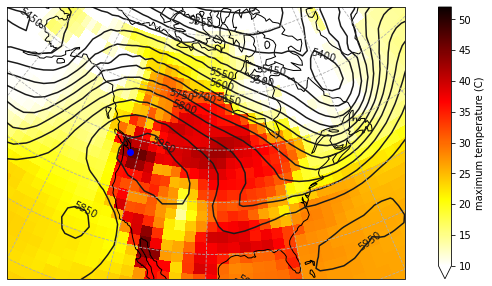

In [69]:
plot_usa(ds_max['tasmax'], ds_max['h500'], outfile='/g/data/xv83/dbi599/seatac/seatac_hottest_day_cafe.pdf')

## JRA-55

In [34]:
#ds_jra_hgt = xr.open_dataset('/g/data/xv83/dbi599/seatac/anl_p125.007_hgt.2021060100_2021063018', engine='cfgrib')
#ds_jra_temp = xr.open_dataset('/g/data/xv83/dbi599/seatac/anl_surf125.011_tmp.2021060100_2021063018', engine='cfgrib')

In [35]:
#ds_jra_hgt_max = ds_jra_hgt.sel({'time': '2021-06-28', 'isobaricInhPa': 500}).mean('time')

In [32]:
ds_era_hgt = xr.open_dataset('/g/data/xv83/dbi599/seatac/h500_ERA5_hourly_2021-06-28.grib', engine='cfgrib')

In [33]:
ds_era_hgt

<xarray.Dataset>
Dimensions:        (latitude: 721, longitude: 1440, time: 24)
Coordinates:
    number         int64 ...
  * time           (time) datetime64[ns] 2021-06-28 ... 2021-06-28T23:00:00
    step           timedelta64[ns] ...
    isobaricInhPa  float64 ...
  * latitude       (latitude) float64 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude      (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time     (time) datetime64[ns] ...
Data variables:
    z              (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-09-21T13:46 GRIB to CDM+CF via cfgrib-0.9.9...

In [38]:
era_h500 = ds_era_hgt['z'].mean('time')

In [52]:
era_h500 = era_h500 / 9.80665

In [41]:
ds_era_tas = xr.open_dataset('/g/data/xv83/dbi599/seatac/tas_ERA5_hourly_2021-06-28.grib', engine='cfgrib')

In [44]:
era_tasmax = ds_era_tas['t2m'].max('time')

In [49]:
era_tasmax = era_tasmax - 273.15

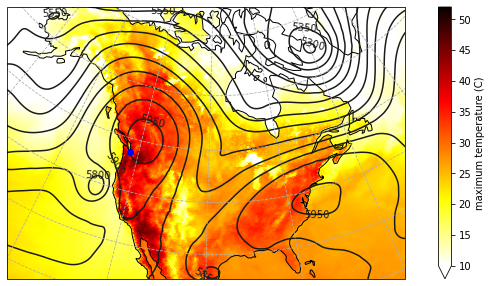

In [70]:
plot_usa(era_tasmax, era_h500, outfile='/g/data/xv83/dbi599/seatac/seatac_2021-06-28_era5.pdf')